# Click-Through Rate Prediction: Predict whether a mobile ad will be clicked
https://www.kaggle.com/c/avazu-ctr-prediction

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from collections import namedtuple
import datetime

## Data Exploration

In [2]:
df = pd.read_csv('../data/filtered_train.csv')
pd.set_option('display.max_columns',None)
df.head()

,Unnamed: 0,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,128037,1.107451e+19,0,14102101,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,10dcdfb1,88fe1d5d,1,0,20352,320,50,2333,0,39,-1,157
1,491755,1.240012e+19,0,14102103,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,9f351a94,3db9fde9,1,0,15701,320,50,1722,0,35,100084,79
2,470924,1.059801e+19,0,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,158aae2e,c144e605,1,0,17614,320,50,1993,2,1063,-1,33
3,791624,1.844219e+18,0,14102104,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,87f758ac,0eb711ec,1,0,16208,320,50,1800,3,167,100075,23
4,491263,1.236016e+19,1,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d55aa41c,3bd9e8e7,1,0,17614,320,50,1993,2,1063,-1,33


In [3]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                404290 non-null  float64
 1   click             404290 non-null  int64  
 2   hour              404290 non-null  int64  
 3   C1                404290 non-null  int64  
 4   banner_pos        404290 non-null  int64  
 5   site_id           404290 non-null  object 
 6   site_domain       404290 non-null  object 
 7   site_category     404290 non-null  object 
 8   app_id            404290 non-null  object 
 9   app_domain        404290 non-null  object 
 10  app_category      404290 non-null  object 
 11  device_id         404290 non-null  object 
 12  device_ip         404290 non-null  object 
 13  device_model      404290 non-null  object 
 14  device_type       404290 non-null  int64  
 15  device_conn_type  404290 non-null  int64  
 16  C14               40

In [5]:
df['click'].value_counts()

click
0    335635
1     68655
Name: count, dtype: int64

In [6]:
df.nunique()

id                  402586
click                    2
hour                   240
C1                       7
banner_pos               7
site_id               2225
site_domain           2188
site_category           22
app_id                2241
app_domain             143
app_category            27
device_id            64742
device_ip           261706
device_model          4380
device_type              4
device_conn_type         4
C14                   2088
C15                      8
C16                      9
C17                    411
C18                      4
C19                     65
C20                    161
C21                     60
dtype: int64

Based on explorative data analysis, hour of the day is be importance

In [7]:
df['hour_of_day'] = df['hour'].astype(str).str.slice(6, 8).astype(int) #hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
df = df.drop('id', axis = 1)
df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day
0,0,14102101,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,10dcdfb1,88fe1d5d,1,0,20352,320,50,2333,0,39,-1,157,1
1,0,14102103,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,9f351a94,3db9fde9,1,0,15701,320,50,1722,0,35,100084,79,3
2,0,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,158aae2e,c144e605,1,0,17614,320,50,1993,2,1063,-1,33,3
3,0,14102104,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,87f758ac,0eb711ec,1,0,16208,320,50,1800,3,167,100075,23,4
4,1,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d55aa41c,3bd9e8e7,1,0,17614,320,50,1993,2,1063,-1,33,3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   click             404290 non-null  int64 
 1   hour              404290 non-null  int64 
 2   C1                404290 non-null  int64 
 3   banner_pos        404290 non-null  int64 
 4   site_id           404290 non-null  object
 5   site_domain       404290 non-null  object
 6   site_category     404290 non-null  object
 7   app_id            404290 non-null  object
 8   app_domain        404290 non-null  object
 9   app_category      404290 non-null  object
 10  device_id         404290 non-null  object
 11  device_ip         404290 non-null  object
 12  device_model      404290 non-null  object
 13  device_type       404290 non-null  int64 
 14  device_conn_type  404290 non-null  int64 
 15  C14               404290 non-null  int64 
 16  C15               404290 non-null  int

## Feature Processing

Based on data explorative analysis using Spark SQL, the predictors `banner_pos`, `site_category`, `device_type`, `app_category` and `hour_of_day` convery important information about CTR.

### cross-product transformation

In [9]:
df['banner_pos-site_category'] = df['banner_pos'].astype(str) + df['site_category']
df['banner_pos-device_type'] = df['banner_pos'].astype(str) + df['device_type'].astype(str)
df['banner_pos-app_category'] = df['banner_pos'].astype(str) + df['app_category']
df['site_category-device_type'] = df['site_category'] + df['device_type'].astype(str)
df['site_category-app_category'] = df['site_category'] + df['app_category']
df['device_type-app_category'] = df['device_type'].astype(str) + df['app_category']

In [10]:
df['hr-app_category'] = df['hour_of_day'].astype(str) + df['app_category']
df['hr-site_category'] = df['hour_of_day'].astype(str) + df['site_category']
df['hr-device_type'] = df['hour_of_day'].astype(str) + df['device_type'].astype(str)
df['hr-banner_pos'] = df['hour_of_day'].astype(str) + df['banner_pos'].astype(str)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   click                       404290 non-null  int64 
 1   hour                        404290 non-null  int64 
 2   C1                          404290 non-null  int64 
 3   banner_pos                  404290 non-null  int64 
 4   site_id                     404290 non-null  object
 5   site_domain                 404290 non-null  object
 6   site_category               404290 non-null  object
 7   app_id                      404290 non-null  object
 8   app_domain                  404290 non-null  object
 9   app_category                404290 non-null  object
 10  device_id                   404290 non-null  object
 11  device_ip                   404290 non-null  object
 12  device_model                404290 non-null  object
 13  device_type                 4

### feature encoding

In [12]:
df.nunique().sort_values(ascending=False)

device_ip                     261706
device_id                      64742
device_model                    4380
app_id                          2241
site_id                         2225
site_domain                     2188
C14                             2088
C17                              411
hr-app_category                  408
hr-site_category                 377
hour                             240
C20                              161
app_domain                       143
hr-banner_pos                    140
hr-device_type                    96
C19                               65
C21                               60
banner_pos-app_category           52
device_type-app_category          48
site_category-app_category        48
banner_pos-site_category          45
app_category                      27
site_category-device_type         26
hour_of_day                       24
site_category                     22
banner_pos-device_type            12
C16                                9
C

In [13]:
df = df.drop(columns=(['device_ip','device_id']))

In [14]:
df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,banner_pos-site_category,banner_pos-device_type,banner_pos-app_category,site_category-device_type,site_category-app_category,device_type-app_category,hr-app_category,hr-site_category,hr-device_type,hr-banner_pos
0,0,14102101,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,88fe1d5d,1,0,20352,320,50,2333,0,39,-1,157,1,1f028772b,11,107d7df22,f028772b1,f028772b07d7df22,107d7df22,107d7df22,1f028772b,11,11
1,0,14102103,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,3db9fde9,1,0,15701,320,50,1722,0,35,100084,79,3,028905ebd,01,007d7df22,28905ebd1,28905ebd07d7df22,107d7df22,307d7df22,328905ebd,31,30
2,0,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,c144e605,1,0,17614,320,50,1993,2,1063,-1,33,3,1f028772b,11,107d7df22,f028772b1,f028772b07d7df22,107d7df22,307d7df22,3f028772b,31,31
3,0,14102104,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,0eb711ec,1,0,16208,320,50,1800,3,167,100075,23,4,1f028772b,11,107d7df22,f028772b1,f028772b07d7df22,107d7df22,407d7df22,4f028772b,41,41
4,1,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,3bd9e8e7,1,0,17614,320,50,1993,2,1063,-1,33,3,1f028772b,11,107d7df22,f028772b1,f028772b07d7df22,107d7df22,307d7df22,3f028772b,31,31


In [15]:
obj_features = list(df.select_dtypes(['object']).columns)
int_features = list(df.select_dtypes(['int64']).columns)
int_features.remove('click')

df[obj_features] = df[obj_features].fillna('-1', )
df[int_features] = df[int_features].fillna(0, )

for feat in obj_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])

In [16]:
sparse_features = df.loc[:, df.nunique() <= 100].columns.tolist()
sparse_features.remove('click')

In [17]:
for feat in sparse_features:
  df_temp = pd.get_dummies(df[feat], prefix=[feat])
  df = df.drop(feat, axis=1)
  df = pd.concat([df, df_temp], axis=1)
df.head()

,click,hour,site_id,site_domain,app_id,app_domain,device_model,C14,C17,C20,hr-app_category,hr-site_category,hr-banner_pos,['C1']_1001,['C1']_1002,['C1']_1005,['C1']_1007,['C1']_1008,['C1']_1010,['C1']_1012,['banner_pos']_0,['banner_pos']_1,['banner_pos']_2,['banner_pos']_3,['banner_pos']_4,['banner_pos']_5,['banner_pos']_7,['site_category']_0,['site_category']_1,['site_category']_2,['site_category']_3,['site_category']_4,['site_category']_5,['site_category']_6,['site_category']_7,['site_category']_8,['site_category']_9,['site_category']_10,['site_category']_11,['site_category']_12,['site_category']_13,['site_category']_14,['site_category']_15,['site_category']_16,['site_category']_17,['site_category']_18,['site_category']_19,['site_category']_20,['site_category']_21,['app_category']_0,['app_category']_1,['app_category']_2,['app_category']_3,['app_category']_4,['app_category']_5,['app_category']_6,['app_category']_7,['app_category']_8,['app_category']_9,['app_category']_10,['app_category']_11,['app_category']_12,['app_category']_13,['app_category']_14,['app_category']_15,['app_category']_16,['app_category']_17,['app_category']_18,['app_category']_19,['app_category']_20,['app_category']_21,['app_category']_22,['app_category']_23,['app_category']_24,['app_category']_25,['app_category']_26,['device_type']_0,['device_type']_1,['device_type']_4,['device_type']_5,['device_conn_type']_0,['device_conn_type']_2,['device_conn_type']_3,['device_conn_type']_5,['C15']_120,['C15']_216,['C15']_300,['C15']_320,['C15']_480,['C15']_728,['C15']_768,['C15']_1024,['C16']_20,['C16']_36,['C16']_50,['C16']_90,['C16']_250,['C16']_320,['C16']_480,['C16']_768,['C16']_1024,['C18']_0,['C18']_1,['C18']_2,['C18']_3,['C19']_33,['C19']_34,['C19']_35,['C19']_38,['C19']_39,['C19']_41,['C19']_43,['C19']_45,['C19']_47,['C19']_161,['C19']_163,['C19']_167,['C19']_169,['C19']_171,['C19']_175,['C19']_289,['C19']_290,['C19']_291,['C19']_295,['C19']_297,['C19']_299,['C19']_303,['C19']_417,['C19']_419,['C19']_423,['C19']_425,['C19']_427,['C19']_431,['C19']_547,['C19']_551,['C19']_553,['C19']_555,['C19']_559,['C19']_673,['C19']_675,['C19']_679,['C19']_681,['C19']_683,['C19']_687,['C19']_801,['C19']_803,['C19']_809,['C19']_811,['C19']_813,['C19']_815,['C19']_935,['C19']_937,['C19']_939,['C19']_943,['C19']_1059,['C19']_1063,['C19']_1065,['C19']_1071,['C19']_1195,['C19']_1315,['C19']_1319,['C19']_1327,['C19']_1447,['C19']_1451,['C19']_1575,['C19']_1583,['C19']_1711,['C19']_1831,['C19']_1835,['C19']_1839,['C21']_1,['C21']_13,['C21']_15,['C21']_16,['C21']_17,['C21']_20,['C21']_23,['C21']_32,['C21']_33,['C21']_35,['C21']_42,['C21']_43,['C21']_46,['C21']_48,['C21']_51,['C21']_52,['C21']_61,['C21']_68,['C21']_69,['C21']_70,['C21']_71,['C21']_76,['C21']_79,['C21']_82,['C21']_85,['C21']_90,['C21']_91,['C21']_93,['C21']_94,['C21']_95,['C21']_100,['C21']_101,['C21']_102,['C21']_104,['C21']_108,['C21']_110,['C21']_111,['C21']_112,['C21']_116,['C21']_117,['C21']_126,['C21']_156,['C21']_157,['C21']_159,['C21']_163,['C21']_171,['C21']_177,['C21']_178,['C21']_182,['C21']_194,['C21']_195,['C21']_204,['C21']_212,['C21']_219,['C21']_221,['C21']_229,['C21']_246,['C21']_251,['C21']_253,['C21']_255,['hour_of_day']_0,['hour_of_day']_1,['hour_of_day']_2,['hour_of_day']_3,['hour_of_day']_4,['hour_of_day']_5,['hour_of_day']_6,['hour_of_day']_7,['hour_of_day']_8,['hour_of_day']_9,['hour_of_day']_10,['hour_of_day']_11,['hour_of_day']_12,['hour_of_day']_13,['hour_of_day']_14,['hour_of_day']_15,['hour_of_day']_16,['hour_of_day']_17,['hour_of_day']_18,['hour_of_day']_19,['hour_of_day']_20,['hour_of_day']_21,['hour_of_day']_22,['hour_of_day']_23,['banner_pos-site_category']_0,['banner_pos-site_category']_1,['banner_pos-site_category']_2,['banner_pos-site_category']_3,['banner_pos-site_category']_4,['banner_pos-site_category']_5,['banner_pos-site_category']_6,['banner_pos-site_category']_7,['banner_pos-site_category']_8,['banner_pos-site_category']_9,['banner_pos-site_category']_10,['banner_pos-site_categ

In [18]:
dense_features = [feat for feat, feat_num in df.nunique().items() if feat_num > 100 and '-' not in feat]
dense_features

['hour',
 'site_id',
 'site_domain',
 'app_id',
 'app_domain',
 'device_model',
 'C14',
 'C17',
 'C20']

In [19]:
df.shape

(404290, 581)

In [20]:
embedding_dict = [{'feat': feat, 'feat_num': df[feat].nunique(), 'embed_dim': 128 if df[feat].nunique() < 256 else 256} for feat in dense_features]
embedding_dict

[{'feat': 'hour', 'feat_num': 240, 'embed_dim': 128},
 {'feat': 'site_id', 'feat_num': 2225, 'embed_dim': 256},
 {'feat': 'site_domain', 'feat_num': 2188, 'embed_dim': 256},
 {'feat': 'app_id', 'feat_num': 2241, 'embed_dim': 256},
 {'feat': 'app_domain', 'feat_num': 143, 'embed_dim': 128},
 {'feat': 'device_model', 'feat_num': 4380, 'embed_dim': 256},
 {'feat': 'C14', 'feat_num': 2088, 'embed_dim': 256},
 {'feat': 'C17', 'feat_num': 411, 'embed_dim': 256},
 {'feat': 'C20', 'feat_num': 161, 'embed_dim': 128}]

In [21]:
for feat in dense_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])

In [22]:
df.head()

,click,hour,site_id,site_domain,app_id,app_domain,device_model,C14,C17,C20,hr-app_category,hr-site_category,hr-banner_pos,['C1']_1001,['C1']_1002,['C1']_1005,['C1']_1007,['C1']_1008,['C1']_1010,['C1']_1012,['banner_pos']_0,['banner_pos']_1,['banner_pos']_2,['banner_pos']_3,['banner_pos']_4,['banner_pos']_5,['banner_pos']_7,['site_category']_0,['site_category']_1,['site_category']_2,['site_category']_3,['site_category']_4,['site_category']_5,['site_category']_6,['site_category']_7,['site_category']_8,['site_category']_9,['site_category']_10,['site_category']_11,['site_category']_12,['site_category']_13,['site_category']_14,['site_category']_15,['site_category']_16,['site_category']_17,['site_category']_18,['site_category']_19,['site_category']_20,['site_category']_21,['app_category']_0,['app_category']_1,['app_category']_2,['app_category']_3,['app_category']_4,['app_category']_5,['app_category']_6,['app_category']_7,['app_category']_8,['app_category']_9,['app_category']_10,['app_category']_11,['app_category']_12,['app_category']_13,['app_category']_14,['app_category']_15,['app_category']_16,['app_category']_17,['app_category']_18,['app_category']_19,['app_category']_20,['app_category']_21,['app_category']_22,['app_category']_23,['app_category']_24,['app_category']_25,['app_category']_26,['device_type']_0,['device_type']_1,['device_type']_4,['device_type']_5,['device_conn_type']_0,['device_conn_type']_2,['device_conn_type']_3,['device_conn_type']_5,['C15']_120,['C15']_216,['C15']_300,['C15']_320,['C15']_480,['C15']_728,['C15']_768,['C15']_1024,['C16']_20,['C16']_36,['C16']_50,['C16']_90,['C16']_250,['C16']_320,['C16']_480,['C16']_768,['C16']_1024,['C18']_0,['C18']_1,['C18']_2,['C18']_3,['C19']_33,['C19']_34,['C19']_35,['C19']_38,['C19']_39,['C19']_41,['C19']_43,['C19']_45,['C19']_47,['C19']_161,['C19']_163,['C19']_167,['C19']_169,['C19']_171,['C19']_175,['C19']_289,['C19']_290,['C19']_291,['C19']_295,['C19']_297,['C19']_299,['C19']_303,['C19']_417,['C19']_419,['C19']_423,['C19']_425,['C19']_427,['C19']_431,['C19']_547,['C19']_551,['C19']_553,['C19']_555,['C19']_559,['C19']_673,['C19']_675,['C19']_679,['C19']_681,['C19']_683,['C19']_687,['C19']_801,['C19']_803,['C19']_809,['C19']_811,['C19']_813,['C19']_815,['C19']_935,['C19']_937,['C19']_939,['C19']_943,['C19']_1059,['C19']_1063,['C19']_1065,['C19']_1071,['C19']_1195,['C19']_1315,['C19']_1319,['C19']_1327,['C19']_1447,['C19']_1451,['C19']_1575,['C19']_1583,['C19']_1711,['C19']_1831,['C19']_1835,['C19']_1839,['C21']_1,['C21']_13,['C21']_15,['C21']_16,['C21']_17,['C21']_20,['C21']_23,['C21']_32,['C21']_33,['C21']_35,['C21']_42,['C21']_43,['C21']_46,['C21']_48,['C21']_51,['C21']_52,['C21']_61,['C21']_68,['C21']_69,['C21']_70,['C21']_71,['C21']_76,['C21']_79,['C21']_82,['C21']_85,['C21']_90,['C21']_91,['C21']_93,['C21']_94,['C21']_95,['C21']_100,['C21']_101,['C21']_102,['C21']_104,['C21']_108,['C21']_110,['C21']_111,['C21']_112,['C21']_116,['C21']_117,['C21']_126,['C21']_156,['C21']_157,['C21']_159,['C21']_163,['C21']_171,['C21']_177,['C21']_178,['C21']_182,['C21']_194,['C21']_195,['C21']_204,['C21']_212,['C21']_219,['C21']_221,['C21']_229,['C21']_246,['C21']_251,['C21']_253,['C21']_255,['hour_of_day']_0,['hour_of_day']_1,['hour_of_day']_2,['hour_of_day']_3,['hour_of_day']_4,['hour_of_day']_5,['hour_of_day']_6,['hour_of_day']_7,['hour_of_day']_8,['hour_of_day']_9,['hour_of_day']_10,['hour_of_day']_11,['hour_of_day']_12,['hour_of_day']_13,['hour_of_day']_14,['hour_of_day']_15,['hour_of_day']_16,['hour_of_day']_17,['hour_of_day']_18,['hour_of_day']_19,['hour_of_day']_20,['hour_of_day']_21,['hour_of_day']_22,['hour_of_day']_23,['banner_pos-site_category']_0,['banner_pos-site_category']_1,['banner_pos-site_category']_2,['banner_pos-site_category']_3,['banner_pos-site_category']_4,['banner_pos-site_category']_5,['banner_pos-site_category']_6,['banner_pos-site_category']_7,['banner_pos-site_category']_8,['banner_pos-site_category']_9,['banner_pos-site_category']_10,['banner_pos-site_categ

In [23]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [24]:
device = torch.device("mps")

In [25]:
device

device(type='mps')

## Pipeline the data

In [26]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train_deep, X_test_deep = train.iloc[:, 1:10], test.iloc[:, 1:10]
X_train_wide, X_test_wide = train.iloc[:, 13:], test.iloc[:, 13:]
Y_train, Y_test = train['click'], test['click']

In [27]:
# Building the output dictionary
wd_dataset = dict()
train_dataset = namedtuple('train_dataset', 'wide, deep, label')
test_dataset  = namedtuple('test_dataset' , 'wide, deep, label')
wd_dataset['train_dataset'] = train_dataset(X_train_wide, X_train_deep, Y_train)
wd_dataset['test_dataset']  = test_dataset(X_test_wide, X_test_deep, Y_test)
wd_dataset['embedding_dict'] = embedding_dict

In [28]:
wd_dataset['train_dataset']

train_dataset(wide=        ['C1']_1001  ['C1']_1002  ['C1']_1005  ['C1']_1007  ['C1']_1008  \
352886        False        False         True        False        False   
134949        False        False         True        False        False   
168419        False        False         True        False        False   
402543        False        False         True        False        False   
13551         False        False         True        False        False   
...             ...          ...          ...          ...          ...   
259178        False        False         True        False        False   
365838        False        False         True        False        False   
131932        False        False         True        False        False   
146867        False        False         True        False        False   
121958        False        False         True        False        False   

        ['C1']_1010  ['C1']_1012  ['banner_pos']_0  ['banner_pos']_1  \
352886  

In [29]:
class WideDeepDataset(Dataset):
    """Helper to facilitate loading the data to the pytorch models.

    Parameters:
    --------
    data: namedtuple with 3 elements - (wide_input_data, deep_inp_data, target)
    """
    def __init__(self, data):

        self.X_wide = torch.tensor(data.wide.values.astype(np.float32))
        self.X_deep =  torch.tensor(data.deep.values.astype(np.float32))
        self.Y =  torch.tensor(data.label.values.astype(np.float32))
        self.Y = self.Y.squeeze().unsqueeze(1)

    def __getitem__(self, idx):

        xw = self.X_wide[idx]
        xd = self.X_deep[idx]
        y  = self.Y[idx]

        return xw, xd, y

    def __len__(self):
        return len(self.Y)

In [30]:
dl_train_dataset = WideDeepDataset(wd_dataset['train_dataset'])
dl_test_dataset = WideDeepDataset(wd_dataset['test_dataset'])

In [31]:
dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size = 128)
dl_val = DataLoader(dl_test_dataset, shuffle=True, batch_size = 128)

In [32]:
# test for traning dara
for (X_wide, X_deep, label) in iter(dl_train):
    print(X_wide.shape, X_deep.shape, label.shape)
    break

torch.Size([128, 568]) torch.Size([128, 9]) torch.Size([128, 1])


## Model building

In [57]:
class Dnn(nn.Module):
    
    def __init__(self, hidden_units, dropout_rate=0., use_bn = False):

        super(Dnn, self).__init__()
        
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(p = dropout_rate)
        self.use_bn = use_bn
        if use_bn:
            self.bn = nn.ModuleList([nn.BatchNorm1d(hidden_units[i + 1]) for i in range(len(hidden_units) - 1)])
    
    def forward(self, x):
        
        for i, linear in enumerate(self.dnn_network):
            x = linear(x)
            if self.use_bn:
                x = self.bn[i](x)
            x = F.relu(x)
            x = self.dropout(x)

        return x

In [34]:
# class WideDeep(nn.Module):
#     def __init__(self, wide_dim, embedding_dict, hidden_units, dropout = 0.):
#         super(WideDeep, self).__init__()
#         self.wide_dim = wide_dim
#         self.deep_dim = 0
#         self.hidden_layers = hidden_units

#         # For each deep feature, create an embedding layer to convert them to embeddings
#         self.embed_layers = nn.ModuleDict({
#             'embed_' + str(i): nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim'])
#             for i, feat in enumerate(embedding_dict)
#         })
#         for feat in embedding_dict:
#             self.deep_dim += int(feat['embed_dim'])
        
#         # A series of hidden layers that take the embeddings as input
#         hidden_units.insert(0, self.deep_dim)
#         self.bn_1 = nn.BatchNorm1d(self.hidden_layers[0])
#         self.dnn_network = Dnn(hidden_units)
#         self.dropout = nn.Dropout(dropout)
#         # Final dense layer that combine the wide features and the deep features and generate output
#         self.fc = nn.Linear(self.wide_dim + self.hidden_layers[-1], 1)

#     def forward(self, X_w, X_d):
#         X_d = X_d.long() # embedding inputs need integer tensors
#         embeddings = [self.embed_layers['embed_' + str(i)](X_d[:, i]) for i in range(X_d.shape[1])]
#         deep_input = torch.cat(embeddings, dim=-1) # concatenate the embeddings of all deep features
#         deep_out = self.dnn_network(deep_input)
        
#         X_w = self.dropout(X_w) # Apply a dropout layer to the wide features for regularization purposes
#         fc_input = torch.cat([X_w, deep_out], dim=-1) # concatenate the wide and processed deep features
#         outputs = self.fc(fc_input)
        
#         return outputs  

In [35]:
# hidden_units = [512, 256, 128]
# dnn_dropout = 0.7

# model = WideDeep(wd_dataset['train_dataset'].wide.shape[1], wd_dataset['embedding_dict'], hidden_units, dnn_dropout)
# model

In [36]:
# # test
# for (X_wide, X_deep, label) in iter(dl_train):
#     out = model(X_wide, X_deep)
#     print(out.shape, label.shape)
#     criterion = nn.BCEWithLogitsLoss()
#     print(criterion(out, label))
#     break

In [37]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# loss_fn = nn.BCEWithLogitsLoss()
# model.to(device)
# # Throw an error when only one class present in y_true, thus need to do error processing
# def auc(y_pred, y_true):
#     pred = y_pred.data
#     y = y_true.data
#     return roc_auc_score(y, pred)
# metric_func = auc
# metric_name = 'auc'

In [38]:
# dfhistory = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])

In [39]:
# n_epoches = 10
# print('Start training......')
# starttime = datetime.datetime.now()
# print('=='* 30)

# for epoch in tqdm(range(1, n_epoches + 1)):
#     loss_sum = 0.0
#     metric_sum = 0.0
#     step = 1

#     for step, (X_wide, X_deep, label) in enumerate(dl_train, 1):
#         X_wide = X_wide.to(device)
#         X_deep = X_deep.to(device)
#         label = label.to(device)
        
#         y_pred = model(X_wide, X_deep)
#         y_pred = y_pred.cpu()
#         label = label.cpu()
#         loss = loss_fn(y_pred, label)
#         try:          
#             metric = metric_func(y_pred, label)
#         except ValueError:
#             pass

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         loss_sum += loss.item()
#         metric_sum += metric.item()

#         if step % 5000 == 0:
#             print(f"Step {step} of Epoch {epoch}:\n\t Average training loss: {loss_sum/step}.\n\t Average auc score: {metric_sum/step}")
            
    
#     # evaluate
#     val_loss_sum = 0.0
#     val_metric_sum = 0.0
#     val_step = 1
#     for val_step, (X_wide, X_deep, label) in enumerate(dl_val, 1):
#         with torch.no_grad():
#             X_wide = X_wide.to(device)
#             X_deep = X_deep.to(device)
#             label = label.to(device)
#             y_pred = model(X_wide, X_deep)
#             y_pred = y_pred.cpu()
#             label = label.cpu()
#             val_loss = loss_fn(y_pred, label)
#             try:          
#                 val_metric = metric_func(y_pred, label)
#             except ValueError:
#                 pass
            
#         val_loss_sum += val_loss.item()
#         val_metric_sum += val_metric.item()
    
#     info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
#     dfhistory.loc[epoch - 1] = info
#     print(f"Epoch {epoch}:\n\t  Average testing loss: {val_loss_sum/val_step}.\n\t Average auc score: {val_metric_sum/val_step}")
#     endtime = datetime.datetime.now()
#     print('Training time fo this epoch is {}'.format(endtime - starttime))
#     print('=='* 20)


# print('Finished Training!')

In [40]:
# dfhistory

### According to Google application, testing for combining sparse features and dense features as dnn input. Compare the result of upper implementation.

In [68]:
class WideDeep_2(nn.Module):
    def __init__(self, wide_dim, embedding_dict, hidden_units, dnn_dropout = 0., linear_dropout = 0., use_bn = False):
        super(WideDeep_2, self).__init__()
        self.wide_dim = wide_dim
        self.deep_dim = 0
        self.hidden_layers = hidden_units

        # For each deep feature, create an embedding layer to convert them to embeddings
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(i): nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim'])
            for i, feat in enumerate(embedding_dict)
        })
        for feat in embedding_dict:
            self.deep_dim += int(feat['embed_dim'])
        
        # A series of hidden layers that take the embeddings as input
        hidden_units.insert(0, self.deep_dim + self.wide_dim)
        self.dnn_network = Dnn(hidden_units, dropout_rate=dnn_dropout, use_bn = use_bn)
        self.linear_dropout = nn.Dropout(linear_dropout) # Apply a dropout layer to the wide features for regularization purposes
        # Final dense layer that combine the wide features and the deep features and generate output
        self.fc = nn.Linear(self.wide_dim + self.hidden_layers[-1], 1)

    def forward(self, X_w, X_d):
        X_d = X_d.long() # embedding inputs need integer tensors
        embeddings = [self.embed_layers['embed_' + str(i)](X_d[:, i]) for i in range(X_d.shape[1])]
        embeddings_cat = torch.cat(embeddings, dim=-1) # concatenate the embeddings of all deep features
        deep_input = torch.cat([X_w, embeddings_cat], axis=-1)
        deep_out = self.dnn_network(deep_input)
        
        X_w = self.linear_dropout(X_w) 
        fc_input = torch.cat([X_w, deep_out], dim=-1) # concatenate the wide and processed deep features
        outputs = self.fc(fc_input)
        
        return outputs  

In [85]:
hidden_units = [128, 64, 32]
dnn_dropout = 0.65
linear_dropout = 0.7

model_2 = WideDeep_2(wd_dataset['train_dataset'].wide.shape[1], wd_dataset['embedding_dict'], hidden_units, dnn_dropout, linear_dropout, use_bn=True)
model_2

WideDeep_2(
  (embed_layers): ModuleDict(
    (embed_0): Embedding(240, 128)
    (embed_1): Embedding(2225, 256)
    (embed_2): Embedding(2188, 256)
    (embed_3): Embedding(2241, 256)
    (embed_4): Embedding(143, 128)
    (embed_5): Embedding(4380, 256)
    (embed_6): Embedding(2088, 256)
    (embed_7): Embedding(411, 256)
    (embed_8): Embedding(161, 128)
  )
  (dnn_network): Dnn(
    (dnn_network): ModuleList(
      (0): Linear(in_features=2488, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=32, bias=True)
    )
    (dropout): Dropout(p=0.65, inplace=False)
    (bn): ModuleList(
      (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (linear_dropout): Dropout(p=0.7

In [86]:
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
model_2.to(device)
# Throw an error when only one class present in y_true, thus need to do error processing
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)
metric_func = auc
metric_name = 'auc'

In [87]:
dfhistory_2 = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])

In [88]:
n_epoches = 20
print('Start training......')
starttime = datetime.datetime.now()
print('=='* 30)

for epoch in tqdm(range(1, n_epoches + 1)):
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1

    for step, (X_wide, X_deep, label) in enumerate(dl_train, 1):
        X_wide = X_wide.to(device)
        X_deep = X_deep.to(device)
        label = label.to(device)
        y_pred = model_2(X_wide, X_deep)
        y_pred = y_pred.cpu()
        label = label.cpu()
        loss = loss_fn(y_pred, label)
        try:          
            metric = metric_func(y_pred, label)
        except ValueError:
            pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        metric_sum += metric.item()

        if step % 5000 == 0:
            print(f"Step {step} of Epoch {epoch}:\n\t Average training loss: {loss_sum/step}.\n\t Average auc score: {metric_sum/step}")
            
    
    # evaluate
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    for val_step, (X_wide, X_deep, label) in enumerate(dl_val, 1):
        with torch.no_grad():
            X_wide = X_wide.to(device)
            X_deep = X_deep.to(device)
            label = label.to(device)
            y_pred = model_2(X_wide, X_deep)
            y_pred = y_pred.cpu()
            label = label.cpu()
            val_loss = loss_fn(y_pred, label)
            try:          
                val_metric = metric_func(y_pred, label)
            except ValueError:
                pass
            
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory_2.loc[epoch - 1] = info
    if epoch % 1 == 0:
        print(f"Epoch {epoch} of {n_epoches}:\n\t  Average testing loss: {val_loss_sum/val_step}.\n\t Average auc score: {val_metric_sum/val_step}")
        endtime = datetime.datetime.now()
        print('Training time is {}'.format(endtime - starttime))
        print('=='* 20)


print('Finished Training!')

Start training......


  5%|▌         | 1/20 [00:37<11:58, 37.84s/it]

Epoch 1 of 20:
	  Average testing loss: 0.42115562262980244.
	 Average auc score: 0.7000541386528338
Training time is 0:00:37.838027


 10%|█         | 2/20 [01:15<11:15, 37.55s/it]

Epoch 2 of 20:
	  Average testing loss: 0.41420897813160207.
	 Average auc score: 0.7174505699747582
Training time is 0:01:15.191412


 15%|█▌        | 3/20 [01:52<10:35, 37.39s/it]

Epoch 3 of 20:
	  Average testing loss: 0.4129457932107056.
	 Average auc score: 0.7223108684215629
Training time is 0:01:52.378326


 20%|██        | 4/20 [02:29<09:56, 37.29s/it]

Epoch 4 of 20:
	  Average testing loss: 0.4117781463774699.
	 Average auc score: 0.7245766669488922
Training time is 0:02:29.523641


 25%|██▌       | 5/20 [03:07<09:21, 37.41s/it]

Epoch 5 of 20:
	  Average testing loss: 0.415373969823122.
	 Average auc score: 0.7253789172460056
Training time is 0:03:07.157831


 30%|███       | 6/20 [03:44<08:45, 37.52s/it]

Epoch 6 of 20:
	  Average testing loss: 0.41365830501234985.
	 Average auc score: 0.7255225347930029
Training time is 0:03:44.893693


 35%|███▌      | 7/20 [04:22<08:08, 37.55s/it]

Epoch 7 of 20:
	  Average testing loss: 0.413281074666147.
	 Average auc score: 0.7253001403040766
Training time is 0:04:22.503069


 40%|████      | 8/20 [05:00<07:31, 37.61s/it]

Epoch 8 of 20:
	  Average testing loss: 0.4172443021796172.
	 Average auc score: 0.7233522527970925
Training time is 0:05:00.231307


 45%|████▌     | 9/20 [05:38<06:54, 37.66s/it]

Epoch 9 of 20:
	  Average testing loss: 0.41549016629593283.
	 Average auc score: 0.7254146074930756
Training time is 0:05:38.021297


 50%|█████     | 10/20 [06:15<06:16, 37.69s/it]

Epoch 10 of 20:
	  Average testing loss: 0.4154539173822614.
	 Average auc score: 0.7251543661161217
Training time is 0:06:15.762556


 55%|█████▌    | 11/20 [06:53<05:38, 37.65s/it]

Epoch 11 of 20:
	  Average testing loss: 0.4185512790668614.
	 Average auc score: 0.7238263824592683
Training time is 0:06:53.311142


 60%|██████    | 12/20 [07:31<05:01, 37.69s/it]

Epoch 12 of 20:
	  Average testing loss: 0.4179776055809063.
	 Average auc score: 0.7257437501646685
Training time is 0:07:31.103802


 65%|██████▌   | 13/20 [08:09<04:25, 37.91s/it]

Epoch 13 of 20:
	  Average testing loss: 0.41905425201299823.
	 Average auc score: 0.7249279553281927
Training time is 0:08:09.521328


 70%|███████   | 14/20 [08:46<03:45, 37.55s/it]

Epoch 14 of 20:
	  Average testing loss: 0.4224336915944196.
	 Average auc score: 0.7223513862981555
Training time is 0:08:46.225231


 75%|███████▌  | 15/20 [09:23<03:06, 37.35s/it]

Epoch 15 of 20:
	  Average testing loss: 0.41947254444224924.
	 Average auc score: 0.7229591654938107
Training time is 0:09:23.136833


 80%|████████  | 16/20 [10:00<02:29, 37.27s/it]

Epoch 16 of 20:
	  Average testing loss: 0.4224663955407052.
	 Average auc score: 0.7229516162810454
Training time is 0:10:00.205040


 85%|████████▌ | 17/20 [10:37<01:51, 37.25s/it]

Epoch 17 of 20:
	  Average testing loss: 0.42357600862278216.
	 Average auc score: 0.7222033512443126
Training time is 0:10:37.399998


 90%|█████████ | 18/20 [11:14<01:14, 37.23s/it]

Epoch 18 of 20:
	  Average testing loss: 0.422141183167696.
	 Average auc score: 0.7216843084178628
Training time is 0:11:14.602136


 95%|█████████▌| 19/20 [11:52<00:37, 37.36s/it]

Epoch 19 of 20:
	  Average testing loss: 0.42809455101437205.
	 Average auc score: 0.7195400915640111
Training time is 0:11:52.249804


100%|██████████| 20/20 [12:30<00:00, 37.51s/it]

Epoch 20 of 20:
	  Average testing loss: 0.4250813597648204.
	 Average auc score: 0.7197435833200896
Training time is 0:12:30.109480
Finished Training!


In [46]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(dfhistory_2)

,epoch,loss,auc,val_loss,val_auc
0,1.0,0.423015,0.693945,0.414025,0.715105
1,2.0,0.411939,0.720105,0.412132,0.718906
2,3.0,0.408951,0.726688,0.411666,0.719892
3,4.0,0.406836,0.730691,0.413383,0.723918
4,5.0,0.405041,0.735040,0.416754,0.724303
5,6.0,0.403386,0.737648,0.418091,0.725000
6,7.0,0.402125,0.740128,0.415675,0.721451
7,8.0,0.400889,0.742612,0.426347,0.723549
8,9.0,0.400528,0.743566,0.422613,0.723968
9,10.0,0.399287,0.745799,0.422627,0.724755


In [47]:
# plot_metric(dfhistory_2, "loss")
# plot_metric(dfhistory_2, "auc")

In [ ]:
# 模型的保存与使用
torch.save(model_2, '../Wide&Deep.pkl')

## Model Evaluation

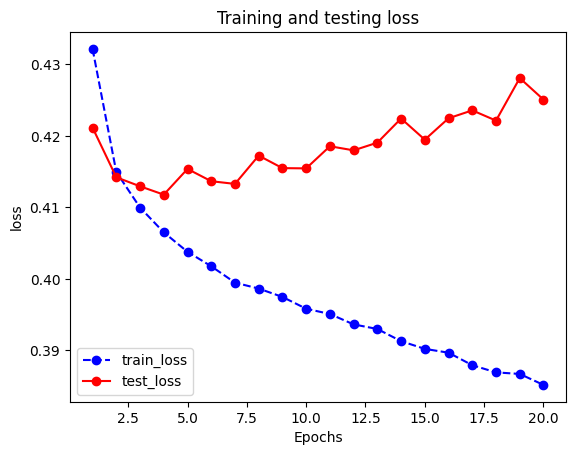

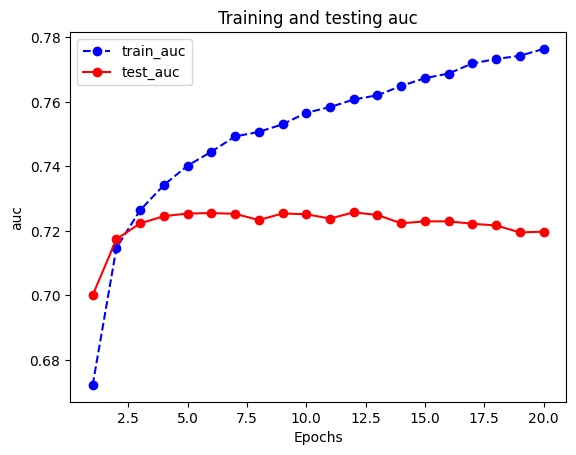

In [89]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and testing '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'test_'+metric])
    plt.show()

plot_metric(dfhistory_2, "loss")
plot_metric(dfhistory_2, "auc")

## Prediction

In [ ]:
y_pred_probs = model_2(torch.tensor(wd_dataset['test_dataset'].wide.values.astype(np.float32)).to(device), torch.tensor(wd_dataset['test_dataset'].deep.values.astype(np.float32)).to(device))
y_pred = torch.where(y_pred_probs > 0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [ ]:
y_pred.data

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])